In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings( 'ignore' )
from sklearn.preprocessing import QuantileTransformer , StandardScaler , MinMaxScaler, RobustScaler
import seaborn as sns
from itertools import combinations
from tqdm import tqdm

In [2]:
train_data = pd.read_csv("./train_open.csv",header = None)
test_data = pd.read_csv("./test_open.csv",header = None)

In [3]:
#columns명 바꿔주기 x0~x31
train_name = []
test_name = []
for _ in range(0 ,31):
    name  = "x"+str(_)
    train_name.append(name)
    test_name.append(name)
train_name.append("label")

train_data.columns = train_name
test_data.columns = test_name

In [4]:
#label값 문자열에서 정수형으로 범주화하기

train_data["y"] = 0

for _ in range(len(train_data.label)):
    if(train_data.label[_] == "A"):
        train_data["y"][_] = 0
    elif(train_data.label[_] == "B"):
        train_data["y"][_] = 1
    elif(train_data.label[_] == "C"):
        train_data["y"][_] = 2
    elif(train_data.label[_] == "D"):
        train_data["y"][_] = 3
    elif(train_data.label[_] == "E"):
        train_data["y"][_] = 4
    elif(train_data.label[_] == "F"):
        train_data["y"][_] = 5

In [5]:
train_data.describe().transpose().to_csv("./데이터_분석.csv",index = False)

# LGBM

In [6]:
x_train, x_test, y_train, y_test = train_test_split(train_data.drop(["label","y"],axis =1 ) , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

In [7]:
from lightgbm import LGBMClassifier
lgbm_model1 = LGBMClassifier(objective = "multiclass",max_depth = 18,num_leaves = 31)
lgbm_model1.fit(x_train,y_train)

lgbm_model1.score(x_test,y_test)

0.9195561719833565

## GridSearch

In [8]:
"""import time
start = time.time()
parameters = {'num_leaves':[30,31,40,60,80,100],'max_depth':[-1,5,10,20,30],
             'learning_rate':[0.05,0.1,0.2,0.3],'reg_alpha':[0,0.01,0.03]}#Define the scoring
clf=GridSearchCV(lgbm_model1,parameters,scoring='accuracy')
clf.fit(X=x_train, y=y_train)
print(clf.best_params_)
end = time.time()
print('Execution time is:')
print(end - start)"""


"import time\nstart = time.time()\nparameters = {'num_leaves':[30,31,40,60,80,100],'max_depth':[-1,5,10,20,30],\n             'learning_rate':[0.05,0.1,0.2,0.3],'reg_alpha':[0,0.01,0.03]}#Define the scoring\nclf=GridSearchCV(lgbm_model1,parameters,scoring='accuracy')\nclf.fit(X=x_train, y=y_train)\nprint(clf.best_params_)\nend = time.time()\nprint('Execution time is:')\nprint(end - start)"

In [9]:
"""clf.score(x_test,y_test)"""

'clf.score(x_test,y_test)'

## lgbm feature 중요도

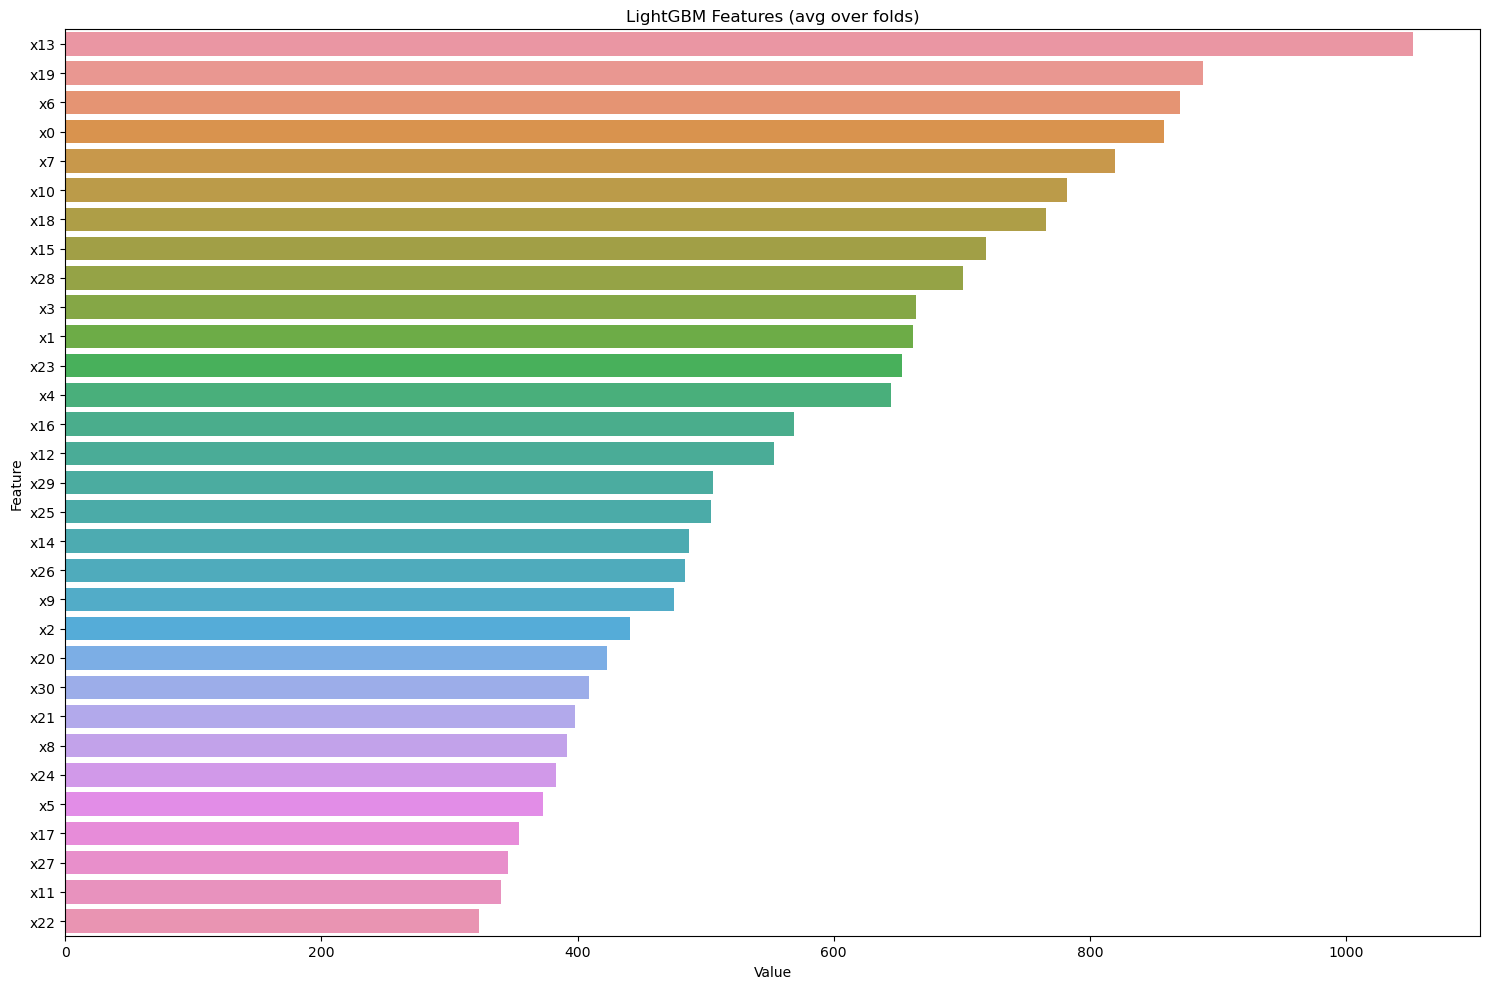

In [10]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_model1.feature_importances_,train_data.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=(feature_imp.sort_values(by="Value", ascending=False)))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## train_data 상관관계

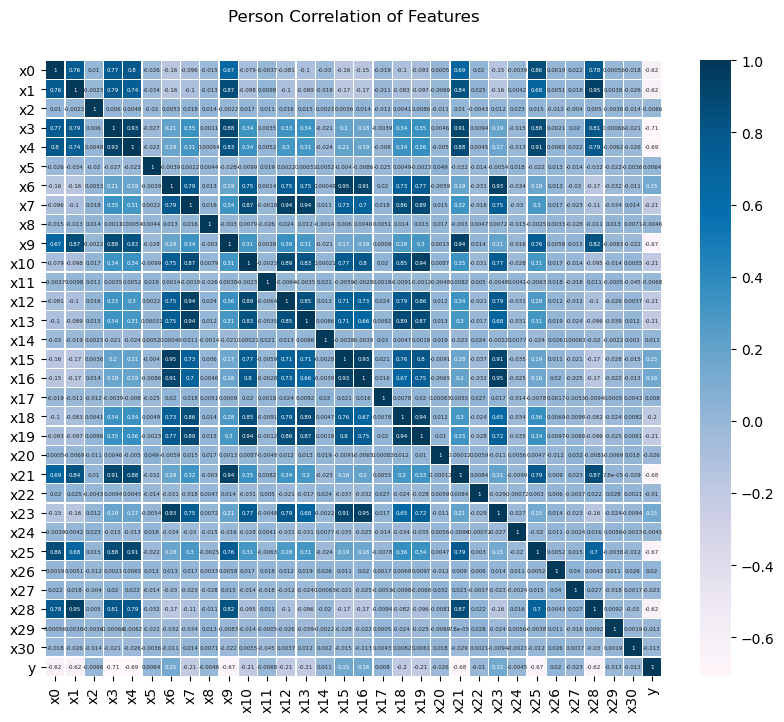

In [11]:
colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05)
sns.heatmap(train_data.drop(["label"],axis =1).astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 4})
plt.show()

In [12]:
cor = train_data.corr()

fea = []
for _ in range(len(cor)):
    if(not cor[(cor[cor.columns[_]]>0.5) & (cor[cor.columns[_]]<1)].index.empty):
        fea.append([cor.columns[_],cor[(cor[cor.columns[_]]>0.80) & (cor[cor.columns[_]]<1)].index])
for _ in range(len(fea)):
    print(fea[_])

['x0', Index(['x25'], dtype='object')]
['x1', Index(['x9', 'x21', 'x28'], dtype='object')]
['x3', Index(['x4', 'x9', 'x21', 'x25', 'x28'], dtype='object')]
['x4', Index(['x3', 'x9', 'x21', 'x25'], dtype='object')]
['x6', Index(['x15', 'x16', 'x23'], dtype='object')]
['x7', Index(['x10', 'x12', 'x13', 'x18', 'x19'], dtype='object')]
['x9', Index(['x1', 'x3', 'x4', 'x21', 'x28'], dtype='object')]
['x10', Index(['x7', 'x12', 'x13', 'x16', 'x18', 'x19'], dtype='object')]
['x12', Index(['x7', 'x10', 'x13', 'x19'], dtype='object')]
['x13', Index(['x7', 'x10', 'x12', 'x18', 'x19'], dtype='object')]
['x15', Index(['x6', 'x16', 'x19', 'x23'], dtype='object')]
['x16', Index(['x6', 'x10', 'x15', 'x23'], dtype='object')]
['x18', Index(['x7', 'x10', 'x13', 'x19'], dtype='object')]
['x19', Index(['x7', 'x10', 'x12', 'x13', 'x15', 'x18'], dtype='object')]
['x21', Index(['x1', 'x3', 'x4', 'x9', 'x28'], dtype='object')]
['x23', Index(['x6', 'x15', 'x16'], dtype='object')]
['x25', Index(['x0', 'x3', 'x4

## train_data 분석

In [13]:
anl = train_data.describe().transpose()
ex1 = anl[(anl["mean"] > 0) & (anl["mean"] <1)]
ex2 = anl[(anl["mean"] > 65) & (anl["mean"] <75)]
ex3 = anl[(anl["mean"] > 75) & (anl["mean"] <85)]
ex3_1 = ex3[(ex3["std"] > 21) & (ex3["std"]<23)]
ex3_2 = ex3[(ex3["std"] > 18) & (ex3["std"]<20)]
ex4 = anl[(anl["mean"] > 95) & (anl["mean"] <105)]
ex5 = anl[(anl["mean"] > 110)]


In [14]:
ex5

,count,mean,std,min,25%,50%,75%,max
x2,3604.0,139.104883,16.468090,90.0,125.0,140.0,153.0,185.0
x13,3604.0,183.814650,22.993104,127.0,171.0,187.0,203.0,232.0
x29,3604.0,113.302164,22.756796,57.0,101.0,115.0,133.0,167.0


## 변수 생성

In [15]:
df_train = pd.DataFrame()

"""
df_train[train_data.columns] = train_data[train_data.columns]
df_test = pd.DataFrame()
df_test[test_data.columns] = test_data[test_data.columns]"""

df_train[train_data.columns] = train_data[train_data.columns]
df_train.drop(["label","y"],axis = 1,inplace = True)
df_test = pd.DataFrame()
df_test[test_data.columns] = test_data[test_data.columns]



newtr4 = df_train[['x7',"x10", 'x12', 'x18', 'x19']]
newte4 = df_test[['x7',"x10", 'x12', 'x18', 'x19']]

#df_train["x13_mean"] = newtr4.mean(axis = 1)
#df_train["x13_var"] = newtr4.var(axis = 1)
#df_train["x13_std"] = newtr4.std(axis = 1)
#df_train["x13_sum"] = newtr4.sum(axis = 1)
#df_train["x13_median"] = newtr4.median(axis = 1)
#df_train["x13_mean_median"] =df_train["x13_mean"]-df_train["x13_median"]
#df_train["x13_max"] = newtr4.max(axis = 1)
#df_train["x13_min"] = newtr4.min(axis = 1)
#df_train["x13_max_min"] = (df_train["x13_max"]- df_train["x13_min"]) 

#df_test["x13_mean"] = newte4.mean(axis = 1)
#df_test["x13_var"] = newte4.var(axis = 1)
#df_test["x13_std"] = newte4.std(axis = 1)
#df_test["x13_sum"] = newte4.sum(axis = 1)
#df_test["x13_median"] = newte4.median(axis = 1)
#df_test["x13_max"] = newte4.max(axis = 1)
#df_test["x13_min"] = newte4.min(axis = 1)
#df_test["x13_max_min"] = (df_test["x13_max"]- df_test["x13_min"]) 


newtr5 = df_train[['x15', 'x16', 'x23']]
newte5 = df_test[['x15', 'x16', 'x23']]

#df_train["x6_mean"] = newtr5.mean(axis = 1)
#df_train["x6_var"] = newtr5.var(axis = 1)
#df_train["x6_std"] = newtr5.std(axis = 1)
#df_train["x6_sum"] = newtr5.sum(axis = 1)
#df_train["x6_median"] = newtr5.median(axis = 1)
df_train["x6_max"] = newtr5.max(axis = 1)
df_train["x6_min"] = newtr5.min(axis = 1)
df_train["x6_max_min"] = (df_train["x6_max"]- df_train["x6_min"])


#df_test["x6_mean"] = newte5.mean(axis = 1)
#df_test["x6_var"] = newte5.var(axis = 1)
#df_test["x6_std"] = newte5.std(axis = 1)
#df_test["x6_sum"] = newte5.sum(axis = 1)
#df_test["x6_median"] = newte5.median(axis = 1)
df_test["x6_max"] = newte5.max(axis = 1)
df_test["x6_min"] = newte5.min(axis = 1)
df_test["x6_max_min"] = (df_test["x6_max"]- df_test["x6_min"])


newtr3 = df_train[['x4', 'x9', 'x21', 'x25']]
newte3 = df_test[['x4', 'x9', 'x21', 'x25']]

#df_train["x3_mean"] = newtr3.mean(axis = 1)
#df_train["x3_var"] = newtr3.var(axis = 1)
#df_train["x3_std"] = newtr3.std(axis = 1)
#df_train["x3_sum"] = newtr3.sum(axis = 1)
#df_train["x3_median"] = newtr3.median(axis = 1)
#df_train["x3_max"] = newtr3.max(axis = 1)
#df_train["x3_min"] = newtr3.min(axis = 1)
#df_train["x3_max_min"] = (df_train["x3_max"]- df_train["x3_min"])

#df_test["x6_mean"] = newte3.mean(axis = 1)
##df_test["x6_var"] = newte3.var(axis = 1)
#df_test["x6_std"] = newte3.std(axis = 1)
#df_test["x6_sum"] = newte3.sum(axis = 1)
#df_test["x6_median"] = newte3.median(axis = 1)

df_train


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x24,x25,x26,x27,x28,x29,x30,x6_max,x6_min,x6_max_min
0,0.610390,88,130,111,115,83,60,98,102,108,...,41,114,63,0.624204,92,91,0.700000,60,53,7
1,0.538961,85,114,111,106,54,84,98,119,108,...,88,105,83,0.579618,85,133,0.576923,84,80,4
2,0.655844,99,129,131,120,77,68,111,82,122,...,88,114,87,0.630573,96,109,0.869231,72,68,4
3,0.642857,100,136,128,123,106,75,116,108,117,...,88,122,59,0.585987,100,101,0.869231,71,66,5
4,0.558442,91,149,114,114,75,93,111,90,115,...,88,110,70,0.477707,87,137,0.669231,92,88,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,0.525974,83,119,101,105,116,87,99,85,105,...,66,100,83,0.426752,83,141,0.723077,87,82,5
3600,0.318182,65,127,74,70,54,53,53,89,78,...,71,72,92,0.624204,65,113,0.376923,53,53,0
3601,0.467532,87,136,104,100,71,71,103,71,104,...,64,86,90,0.541401,87,64,0.553846,76,75,1
3602,0.558442,91,149,114,101,111,85,102,123,102,...,76,105,58,0.407643,87,124,0.623077,84,72,12


In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 5 , include_bias = False)
poly.fit(train_data[['x7', 'x10', 'x12', 'x18', 'x19']])
train_poly = poly.transform(train_data[['x7', 'x10', 'x12', 'x18', 'x19']])
train_poly = pd.DataFrame(train_poly,columns = poly.get_feature_names(['x7', 'x10', 'x12', 'x18', 'x19']))

test_poly = poly.transform(test_data[['x7', 'x10', 'x12', 'x18', 'x19']])
test_poly = pd.DataFrame(test_poly,columns = poly.get_feature_names(['x7', 'x10', 'x12', 'x18', 'x19']))

train_poly_data = pd.DataFrame()
train_poly_data[df_train.columns] = df_train[df_train.columns]

test_poly_data = pd.DataFrame()
test_poly_data[df_test.columns] = df_test[df_test.columns]

train_poly_data[train_poly.columns] = train_poly[train_poly.columns]
test_poly_data[test_poly.columns] = test_poly[test_poly.columns]

train_poly_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12 x18^3 x19,x12 x18^2 x19^2,x12 x18 x19^3,x12 x19^4,x18^5,x18^4 x19,x18^3 x19^2,x18^2 x19^3,x18 x19^4,x19^5
0,0.610390,88,130,111,115,83,60,98.0,102,108,...,8.843801e+09,9.299667e+09,9.779032e+09,1.028311e+10,8.587340e+09,9.029987e+09,9.495450e+09,9.984906e+09,1.049959e+10,1.104081e+10
1,0.538961,85,114,111,106,54,84,98.0,119,108,...,8.854753e+09,8.946040e+09,9.038267e+09,9.131445e+09,8.587340e+09,8.675870e+09,8.765311e+09,8.855676e+09,8.946971e+09,9.039208e+09
2,0.655844,99,129,131,120,77,68,111.0,82,122,...,1.700239e+10,1.700239e+10,1.700239e+10,1.700239e+10,1.685058e+10,1.685058e+10,1.685058e+10,1.685058e+10,1.685058e+10,1.685058e+10
3,0.642857,100,136,128,123,106,75,116.0,108,117,...,1.762201e+10,1.746467e+10,1.730874e+10,1.715420e+10,1.762342e+10,1.746606e+10,1.731012e+10,1.715556e+10,1.700239e+10,1.685058e+10
4,0.558442,91,149,114,114,75,93,111.0,90,115,...,1.482177e+10,1.454729e+10,1.427790e+10,1.401349e+10,1.469328e+10,1.442118e+10,1.415412e+10,1.389201e+10,1.363475e+10,1.338226e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,0.525974,83,119,101,105,116,87,99.0,85,105,...,9.603000e+09,9.506970e+09,9.411900e+09,9.317781e+09,1.000000e+10,9.900000e+09,9.801000e+09,9.702990e+09,9.605960e+09,9.509900e+09
3600,0.318182,65,127,74,70,54,53,53.0,89,78,...,4.923899e+08,4.832716e+08,4.743221e+08,4.655384e+08,4.591650e+08,4.506620e+08,4.423164e+08,4.341253e+08,4.260860e+08,4.181955e+08
3601,0.467532,87,136,104,100,71,71,103.0,71,104,...,4.787752e+09,5.378832e+09,6.042886e+09,6.788921e+09,3.486784e+09,3.917252e+09,4.400863e+09,4.944179e+09,5.554572e+09,6.240321e+09
3602,0.558442,91,149,114,101,111,85,102.0,123,102,...,9.462356e+09,8.793300e+09,8.171552e+09,7.593765e+09,9.509900e+09,8.837483e+09,8.212611e+09,7.631921e+09,7.092290e+09,6.590815e+09


In [17]:
#scaler = StandardScaler()
"""scaler = QuantileTransformer()
scaler.fit(df_train.drop(["label","y"],axis = 1))

df_train_sc=pd.DataFrame()
df_train_sc[df_train.drop(["label","y"],axis = 1).columns] =df_train[df_train.drop(["label","y"],axis = 1).columns]
df_train_sc[df_train.drop(["label","y"],axis = 1).columns] = scaler.transform(df_train.drop(["label","y"],axis = 1) )


test_data_sc=pd.DataFrame()
test_data_sc[test_data.columns] = test_data[test_data.columns]
#test_data_sc[["x20","x26","x29"]] = scaler.transform(test_data[["x20","x26","x29"]] )"""

'scaler = QuantileTransformer()\nscaler.fit(df_train.drop(["label","y"],axis = 1))\n\ndf_train_sc=pd.DataFrame()\ndf_train_sc[df_train.drop(["label","y"],axis = 1).columns] =df_train[df_train.drop(["label","y"],axis = 1).columns]\ndf_train_sc[df_train.drop(["label","y"],axis = 1).columns] = scaler.transform(df_train.drop(["label","y"],axis = 1) )\n\n\ntest_data_sc=pd.DataFrame()\ntest_data_sc[test_data.columns] = test_data[test_data.columns]\n#test_data_sc[["x20","x26","x29"]] = scaler.transform(test_data[["x20","x26","x29"]] )'

## 변수 생성 후 lgbm

In [18]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(df_train, train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

In [19]:
df_train.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x6_max', 'x6_min', 'x6_max_min'],
      dtype='object')

In [20]:
lgbm_model2 = LGBMClassifier()
lgbm_model2.fit(x_train1,y_train1)

lgbm_model2.score(x_test1,y_test1)

0.9195561719833565

# Permutaion Importance

In [21]:
"""from sklearn.inspection import permutation_importance 
result = permutation_importance(lgbm_model1, train_data.drop(["label","y"],axis =1 ) , train_data.y,
                                scoring = "accuracy",n_repeats=20,random_state=0,n_jobs=-1)
"""

'from sklearn.inspection import permutation_importance \nresult = permutation_importance(lgbm_model1, train_data.drop(["label","y"],axis =1 ) , train_data.y,\n                                scoring = "accuracy",n_repeats=20,random_state=0,n_jobs=-1)\n'

In [22]:
"""
# Feature label
Feature = train_data.drop(["label","y"],axis =1 )

# Feature 중요도를 오름차순으로 정렬한 뒤, 해당 Feature 의 index 를 저장
sorted_result = result.importances_mean.argsort()

# 결과를 DataFrame 화
importances = pd.DataFrame(result.importances_mean[sorted_result], index=Feature.columns[sorted_result]).sort_values(0, ascending=False)   
importances.columns = ["imp"]
importances"""

'\n# Feature label\nFeature = train_data.drop(["label","y"],axis =1 )\n\n# Feature 중요도를 오름차순으로 정렬한 뒤, 해당 Feature 의 index 를 저장\nsorted_result = result.importances_mean.argsort()\n\n# 결과를 DataFrame 화\nimportances = pd.DataFrame(result.importances_mean[sorted_result], index=Feature.columns[sorted_result]).sort_values(0, ascending=False)   \nimportances.columns = ["imp"]\nimportances'

In [23]:
"""gar = []
for _ in range (len(importances)):
    if(importances.imp[_] <= 0 ):
        gar.append(importances.index[_])
gar.append("label")
gar.append("y")"""

'gar = []\nfor _ in range (len(importances)):\n    if(importances.imp[_] <= 0 ):\n        gar.append(importances.index[_])\ngar.append("label")\ngar.append("y")'

In [24]:
"""plt.figure(figsize=(8,4))
plt.xticks(range(0, 3605, 10), rotation=60)
sns.distplot(df_train['x9'])
plt.show()"""

"plt.figure(figsize=(8,4))\nplt.xticks(range(0, 3605, 10), rotation=60)\nsns.distplot(df_train['x9'])\nplt.show()"

# 여러가지 LGBM 모델 만들기

## 변수 생성 2

In [25]:
def make_fea(train_data,test_data,col):
        df_train = pd.DataFrame()
    
        """
        df_train[train_data.columns] = train_data[train_data.columns]
        df_test = pd.DataFrame()
        df_test[test_data.columns] = test_data[test_data.columns]"""

        df_train[train_data.columns] = train_data[train_data.columns]
        df_train.drop(["label","y"],axis = 1,inplace = True)
        df_test = pd.DataFrame()
        df_test[test_data.columns] = test_data[test_data.columns]

        for _ in range(len(col)):
            
            
            if col[_] == "x13":
            
                newtr4 = df_train[['x7',"x10", 'x12', 'x18', 'x19']]
                newte4 = df_test[['x7',"x10", 'x12', 'x18', 'x19']]

                #df_train["x13_mean"] = newtr4.mean(axis = 1)
                #df_train["x13_var"] = newtr4.var(axis = 1)
                #df_train["x13_std"] = newtr4.std(axis = 1)
                #df_train["x13_sum"] = newtr4.sum(axis = 1)
                #df_train["x13_median"] = newtr4.median(axis = 1)
                #df_train["x13_mean_median"] =df_train["x13_mean"]-df_train["x13_median"]
                df_train["x13_max"] = newtr4.max(axis = 1)
                df_train["x13_min"] = newtr4.min(axis = 1)
                df_train["x13_max_min"] = (newtr4.max(axis = 1) -  newtr4.min(axis = 1)) 
                #df_train["x13_max_min#"] = np.sqrt(((newtr4.max(axis = 1)**2) -  (newtr4.min(axis = 1))**2))
                #df_train["x13_max_min^2"] = ((newtr4.max(axis = 1) -  newtr4.min(axis = 1)))**2
                #df_train["x13_"] = df_train["x13_max_min"] * df_train["x13"]


                #df_test["x13_mean"] = newte4.mean(axis = 1)
                #df_test["x13_var"] = newte4.var(axis = 1)
                #df_test["x13_std"] = newte4d.std(axis = 1)
                #df_test["x13_sum"] = newte4.sum(axis = 1)
                #df_test["x13_median"] = newte4.median(axis = 1)
                df_test["x13_max"] = newte4.max(axis = 1)
                df_test["x13_min"] = newte4.min(axis = 1)
                df_test["x13_max_min"] = (newte4.max(axis = 1) -  newte4.min(axis = 1)) 
                #f_test["x13_max_min#"] = np.sqrt(((newte4.max(axis = 1)**2) -  (newte4.min(axis = 1))**2))
                #df_test["x13_max_min^2"] = ((newte4.max(axis = 1) -  newte4.min(axis = 1)))**2 
                #df_test["x13_"] = df_test["x13_max_min"] * df_test["x13"]

            
            elif col[_] == "x6":
                newtr5 = df_train[['x15', 'x16', 'x23']]
                newte5 = df_test[['x15', 'x16', 'x23']]

                #df_train["x6_mean"] = newtr5.mean(axis = 1)
                #df_train["x6_var"] = newtr5.var(axis = 1)
                #df_train["x6_std"] = newtr5.std(axis = 1)
                #df_train["x6_sum"] = newtr5.sum(axis = 1)
                #df_train["x6_median"] = newtr5.median(axis = 1)
                #df_train["x6_max"] = newtr5.max(axis = 1)
                #df_train["x6_min"] = newtr5.min(axis = 1)
                df_train["x6_max_min"] = (newtr5.max(axis = 1)- newtr5.min(axis = 1))


                #df_test["x6_mean"] = newte5.mean(axis = 1)
                #df_test["x6_var"] = newte5.var(axis = 1)
                #df_test["x6_std"] = newte5.std(axis = 1)
                #df_test["x6_sum"] = newte5.sum(axis = 1)
                #df_test["x6_median"] = newte5.median(axis = 1)
                #df_test["x6_max"] = newte5.max(axis = 1)
                #df_test["x6_min"] = newte5.min(axis = 1)
                df_test["x6_max_min"] = (newte5.max(axis = 1)- newte5.min(axis = 1))
            
            elif col[_] == "x0":
                newtr2 = df_train[[ 'x0',  'x27',"x30"]]
                newte2 = df_test[[ 'x0', 'x27',"x30"]]

                #df_train["x0_mean"] = newtr2.mean(axis = 1)
                #df_train["x0_var"] = newtr2.var(axis = 1)
                #df_train["x0_std"] = newtr2.std(axis = 1)
                #df_train["x0_sum"] = newtr2.sum(axis = 1)
                #df_train["x0_median"] = newtr2.median(axis = 1)

                #df_test["x0_mean"] = newte2.mean(axis = 1)
                #df_test["x0_var"] = newte2.var(axis = 1)
                #df_test["x0_std"] = newte2.std(axis = 1)
                #df_test["x0_sum"] = newte2.sum(axis = 1)
                #df_test["x0_median"] = newte2.median(axis = 1)
                
            
            elif col[_] == "x3":

                newtr3 = df_train[["x4", 'x9', 'x21', 'x25']]
                newte3 = df_test[["x4",'x9', 'x21', 'x25']]

                #df_train["x3_mean"] = newtr3.mean(axis = 1)
                #df_train["x3_var"] = newtr3.var(axis = 1)
                #df_train["x3_std"] = newtr3.std(axis = 1)
                #df_train["x3_sum"] = newtr3.sum(axis = 1)
                #df_train["x3_median"] = newtr3.median(axis = 1)
                df_train["x3_max"] = newtr3.max(axis = 1)
                df_train["x3_min"] = newtr3.min(axis = 1)
                df_train["x3_max_min"] = (df_train["x3_max"]- df_train["x3_min"])

                #df_test["x3_mean"] = newte3.mean(axis = 1)
                #df_test["x3_var"] = newte3.var(axis = 1)
                #df_test["x3_std"] = newte3.std(axis = 1)
                #df_test["x3_sum"] = newte3.sum(axis = 1)
                #df_test["x3_median"] = newte3.median(axis = 1)
                df_test["x3_max"] = newte3.max(axis = 1)
                df_test["x3_min"] = newte3.min(axis = 1)
                df_test["x3_max_min"] = (df_test["x3_max"]- df_test["x3_min"])

                
            elif col[_] == "x28":
                
                newtr6 = df_train[["x9","x21"]]
                newte6 = df_test[["x9","x21"]]

                #df_train["x28_mean"] = newtr3.mean(axis = 1)
                #df_train["x28_var"] = newtr3.var(axis = 1)
                #df_train["x28_std"] = newtr3.std(axis = 1)
                #df_train["x28_sum"] = newtr3.sum(axis = 1)
                #df_train["x28_median"] = newtr3.median(axis = 1)
                df_train["x28_max"] = newtr6.max(axis = 1)
                df_train["x28_min"] = newtr6.min(axis = 1)
                #df_train["x28_max_min"] = (df_train["x28_max"]- df_train["x28_min"])

                df_test["x28_max"] = newte6.max(axis = 1)
                df_test["x28_min"] = newte6.min(axis = 1)
                #df_test["x28_max_min"] = (df_test["x28_max"]- df_test["x28_min"])
                
           
            elif col[_] == "x19":
                newtr7 = df_train[['x7', 'x10', 'x12', 'x18']]
                newte7 = df_test[['x7', 'x10', 'x12', 'x18']]

                #df_train["x19_mean"] = newtr7.mean(axis = 1)
                #df_train["x19_var"] = newtr7.var(axis = 1)
                #df_train["x19_std"] = newtr7.std(axis = 1)
                #df_train["x19_sum"] = newtr7.sum(axis = 1)
                #df_train["x19_median"] = newtr7.median(axis = 1)
                df_train["x19_max"] = newtr7.max(axis = 1)
                df_train["x19_min"] = newtr7.min(axis = 1)
                df_train["x19_max_min"] = (df_train["x19_max"]- df_train["x19_min"])

                #df_test["x19_mean"] = newte7.mean(axis = 1)
                #df_test["x19_var"] = newte7.var(axis = 1)
                #df_test["x19_std"] = newte7.std(axis = 1)
                #df_test["x19_sum"] = newte7.sum(axis = 1)
                #df_test["x19_median"] = newte7.median(axis = 1)
                df_test["x19_max"] = newte7.max(axis = 1)
                df_test["x19_min"] = newte7.min(axis = 1)
                df_test["x19_max_min"] = (df_test["x19_max"]- df_test["x19_min"])

        
        return df_train,df_test

In [26]:
df_train_x13,df_test_x13 = make_fea(train_data,test_data,["x13"])

df_train_x28,df_test_x28 = make_fea(train_data,test_data,["x28"])

df_train_x6,df_test_x6 = make_fea(train_data,test_data,["x6"])

df_train_x13_x3,df_test_x13_x3 = make_fea(train_data,test_data,["x13","x3"])

df_train_x3,df_test_x3 = make_fea(train_data,test_data,["x3"])

df_train_x19,df_test_x19 = make_fea(train_data,test_data,["x19"])



In [27]:
df_train_x13_x3

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x27,x28,x29,x30,x13_max,x13_min,x13_max_min,x3_max,x3_min,x3_max_min
0,0.610390,88,130,111,115,83,60,98,102,108,...,0.624204,92,91,0.700000,102,95,7,115,108,7
1,0.538961,85,114,111,106,54,84,98,119,108,...,0.579618,85,133,0.576923,99,97,2,108,105,3
2,0.655844,99,129,131,120,77,68,111,82,122,...,0.630573,96,109,0.869231,112,111,1,128,114,14
3,0.642857,100,136,128,123,106,75,116,108,117,...,0.585987,100,101,0.869231,116,111,5,123,117,6
4,0.558442,91,149,114,114,75,93,111,90,115,...,0.477707,87,137,0.669231,111,106,5,115,110,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,0.525974,83,119,101,105,116,87,99,85,105,...,0.426752,83,141,0.723077,102,97,5,105,100,5
3600,0.318182,65,127,74,70,54,53,53,89,78,...,0.624204,65,113,0.376923,59,49,10,78,70,8
3601,0.467532,87,136,104,100,71,71,103,71,104,...,0.541401,87,64,0.553846,103,81,22,104,86,18
3602,0.558442,91,149,114,101,111,85,102,123,102,...,0.407643,87,124,0.623077,106,92,14,105,101,4


In [28]:

def eva(comb,df_train2,num):#lgbm
        sco = []
        print("combination length : ",len(comb))
        x_train0, x_test0, y_train0, y_test0 = train_test_split(df_train2,train_data.y ,
                                                                    test_size=0.2,random_state= 2022,shuffle = True) 
        
        lgbm_model0 = LGBMClassifier(objective = "multiclass")
        lgbm_model0.fit(x_train0,y_train0)
        print(lgbm_model0.score(x_test0,y_test0))
        for _ in (range(len(comb))):
            ex = pd.DataFrame()
            ex[df_train2.columns] = df_train2[df_train2.columns]
            for i in range(num): 
                ex = ex.drop([df_train2.columns[comb[_][i]]],axis =1 )

            x_train0, x_test0, y_train0, y_test0 = train_test_split(ex,train_data.y ,
                                                                    test_size=0.2,random_state= 2022,shuffle = True) 

            lgbm_model0 = LGBMClassifier(objective = "multiclass")
            lgbm_model0.fit(x_train0,y_train0)
            sco.append(lgbm_model0.score(x_test0,y_test0))
            if (_ % 100) == 0:   
                print(_)
            #print("drop ",df_train2.columns[comb[_]]," : " ,lgbm_model0.score(x_test0,y_test0))
        return sco


## 변수 생성 3

In [29]:
def make_fea2(train_data,test_data):
        #df_train = pd.DataFrame()
        df_train1 = pd.DataFrame()
        df_train2 = pd.DataFrame()
        df_train3 = pd.DataFrame()
        df_train4 = pd.DataFrame()
        df_train5 = pd.DataFrame()
        
        df_test1 = pd.DataFrame()
        df_test2 = pd.DataFrame()
        df_test3 = pd.DataFrame()
        df_test4 = pd.DataFrame()
        df_test5 = pd.DataFrame()
        """
        df_train[train_data.columns] = train_data[train_data.columns]
        df_test = pd.DataFrame()
        df_test[test_data.columns] = test_data[test_data.columns]"""

        df_train1[train_data.columns] = train_data[train_data.columns]
        df_train2[train_data.columns] = train_data[train_data.columns]
        df_train3[train_data.columns] = train_data[train_data.columns]
        df_train4[train_data.columns] = train_data[train_data.columns]
        df_train5[train_data.columns] = train_data[train_data.columns]
        #df_train.drop(["label","y"],axis = 1,inplace = True)
        
        df_test1[test_data.columns] = test_data[test_data.columns]
        df_test2[test_data.columns] = test_data[test_data.columns]
        df_test3[test_data.columns] = test_data[test_data.columns]
        df_test4[test_data.columns] = test_data[test_data.columns]
        df_test5[test_data.columns] = test_data[test_data.columns]
        
        
        df_train1.drop(["label","y"],axis = 1,inplace = True)
        df_train2.drop(["label","y"],axis = 1,inplace = True)
        df_train3.drop(["label","y"],axis = 1,inplace = True)
        df_train4.drop(["label","y"],axis = 1,inplace = True)
        df_train5.drop(["label","y"],axis = 1,inplace = True)
        
        """df_test1.drop(["label","y"],axis = 1,inplace = True)
        df_test2.drop(["label","y"],axis = 1,inplace = True)
        df_test3.drop(["label","y"],axis = 1,inplace = True)
        df_test4.drop(["label","y"],axis = 1,inplace = True)
        df_test5.drop(["label","y"],axis = 1,inplace = True)"""
    
     
        newtr1 = df_train1[["x27","x0"]]
        newte1 = df_test1[["x27","x0"]]
        
        #df_train1["col1_mean"] = newtr1.mean(axis = 1)
        #df_train1["col1_var"] = newtr1.var(axis = 1)
        #df_train1["col1_std"] = newtr1.std(axis = 1)
        #df_train1["col1_sum"] = newtr1.sum(axis = 1)
        #df_train1["col1_median"] = newtr1.median(axis = 1)
        df_train1["col1_max"] = newtr1.max(axis = 1)
        df_train1["col1_min"] = newtr1.min(axis = 1)
        df_train1['col1_max_min'] = newtr1.max(axis =1 ) - newtr1.min(axis =1)
        
        x_train1, x_test1, y_train1, y_test1 = train_test_split(df_train1 , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True)
        lgbm_model1 = LGBMClassifier(objective = "multiclass")
        lgbm_model1.fit(x_train1,y_train1)
        print("1. ",lgbm_model1.score(x_test1,y_test1))
        
        num1 = list(range(0,len(df_train1.columns)))
        comb1 = list(combinations(num1,1))
        #eva(comb1,df_train1)
        
        #df_test1["col1_mean"] = newte1.mean(axis = 1)
        #df_test1["col1_var"] = newte1.var(axis = 1)
        #df_test1["col1_std"] = newte1.std(axis = 1)
        #df_test1["col1_sum"] = newte1.sum(axis = 1)
        #df_test1["col1_median"] = newte1.median(axis = 1)
        df_test1["col1_max"] = newte1.max(axis = 1)
        df_test1["col1_min"] = newte1.min(axis = 1)
        df_test1['col1_max_min'] = newte1.max(axis =1) - newte1.min(axis =1)
        
        newtr2 = df_train2[["x6","x15","x16","x17","x23","x24"]]
        newte2 = df_test2[["x6","x15","x16","x17","x23","x24"]]
        
        #df_train2["col2_mean"] = newtr2.mean(axis = 1)
        #df_train2["col2_var"] = newtr2.var(axis = 1)
        #df_train2["col2_std"] = newtr2.std(axis = 1)
        #df_train2["col2_sum"] = newtr2.sum(axis = 1)
        #df_train2["col2_median"] = newtr2.median(axis = 1)
        df_train2["col2_max"] = newtr2.max(axis = 1)
        df_train2["col2_min"] = newtr2.min(axis = 1)
        df_train2['col2_max_min'] = newtr2.max(axis =1) - newtr2.min(axis =1)
        
        x_train2, x_test2, y_train2, y_test2 = train_test_split(df_train2 , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True)
        lgbm_model2 = LGBMClassifier(objective = "multiclass")
        lgbm_model2.fit(x_train2,y_train2)
        print("2. ",lgbm_model2.score(x_test2,y_test2))
        
        num2 = list(range(0,len(df_train3.columns)))
        comb2 = list(combinations(num2,1))
        #eva(comb2,df_train2)
        
        
        #df_test2["col2_mean"] = newte2.mean(axis = 1)
        #df_test2["col2_var"] = newte2.var(axis = 1)
        #df_test2["col2_std"] = newte2.std(axis = 1)
        #df_test2["col2_sum"] = newte2.sum(axis = 1)
        #df_test2["col2_median"] = newte2.median(axis = 1)
        df_test2["col2_max"] = newte2.max(axis = 1)
        df_test2["col2_min"] = newte2.min(axis = 1)
        df_test2['col2_max_min'] = newte2.max(axis =1 ) - newte2.min(axis =1)
        
        newtr3 = df_train3[["x1","x14","x22","x26","x28"]]
        newte3 = df_test3[["x1","x14","x22","x26","x28"]]
        
        #df_train3["col3_mean"] = newtr3.mean(axis = 1)
        #df_train3["col3_var"] = newtr3.var(axis = 1)
        #df_train3["col3_std"] = newtr3.std(axis = 1)
        #df_train3["col3_sum"] = newtr3.sum(axis = 1)
        #df_train3["col3_median"] = newtr3.median(axis = 1)
        df_train3["col3_max"] = newtr3.max(axis = 1)
        df_train3["col3_min"] = newtr3.min(axis = 1)
        df_train3['col3_max_min'] = newtr3.max(axis =1 ) - newtr3.min(axis =1)

        
        x_train3, x_test3, y_train3, y_test3 = train_test_split(df_train3 , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True)
        lgbm_model3 = LGBMClassifier(objective = "multiclass")
        lgbm_model3.fit(x_train3,y_train3)
        print("3. ",lgbm_model3.score(x_test3,y_test3))
        
        num3 = list(range(0,len(df_train3.columns)))
        comb3 = list(combinations(num3,1))
        #eva(comb3,df_train3)
        
        #df_test3["col3_mean"] = newte3.mean(axis = 1)
        #df_test3["col3_var"] = newte3.var(axis = 1)
        #df_test3["col3_std"] = newte3.std(axis = 1)
        #df_test3["col3_sum"] = newte3.sum(axis = 1)
        #df_test3["col3_median"] = newte3.median(axis = 1)
        df_test3["col3_max"] = newte3.max(axis = 1)
        df_test3["col3_min"] = newte3.min(axis = 1)
        df_test3['col3_max_min'] = newte3.max(axis =1 ) - newte3.min(axis =1)
       
        newtr4 = df_train4[["x7","x10","x12","x18","x19"]]
        newte4 = df_test4[["x7","x10","x12","x18","x19"]]
        
        #df_train4["col4_mean"] = newtr4.mean(axis = 1)
        #df_train4["col4_var"] = newtr4.var(axis = 1)
        #df_train4["col4_std"] = newtr4.std(axis = 1)
        #df_train4["col4_sum"] = newtr4.sum(axis = 1)
        #df_train4["col4_median"] = newtr4.median(axis = 1)
        df_train4["col4_max"] = newtr4.max(axis = 1)
        df_train4["col4_min"] = newtr4.min(axis = 1)
        df_train4['col4_max_min'] = newtr4.max(axis =1 ) - newtr4.min(axis =1)
        
        num4 = list(range(0,len(df_train4.columns)))
        comb4 = list(combinations(num4,1))
        #eva(comb4,df_train4)
        
        
        
        
        x_train4, x_test4, y_train4, y_test4 = train_test_split(df_train4 , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True)
        lgbm_model4 = LGBMClassifier(objective = "multiclass")
        lgbm_model4.fit(x_train4,y_train4)
        print("4. ",lgbm_model4.score(x_test4,y_test4))
        
        #df_test4["col4_mean"] = newte4.mean(axis = 1)
        #df_test4["col4_var"] = newte4.var(axis = 1)
        #df_test4["col4_std"] = newte4.std(axis = 1)
        #df_test4["col4_sum"] = newte4.sum(axis = 1)
        #df_test4["col4_median"] = newte4.median(axis = 1)
        df_test4["col4_max"] = newte4.max(axis = 1)
        df_test4["col4_min"] = newte4.min(axis = 1)
        df_test4['col4_max_min'] = newte4.max(axis =1 ) - newte4.min(axis =1)
        
       
        newtr5 = df_train5[["x3","x4","x8","x9","x21","x25"]]
        newte5 = df_test5[["x3","x4","x8","x9","x21","x25"]]
        
        #df_train5["col5_mean"] = newtr5.mean(axis = 1)
        #df_train5["col5_var"] = newtr5.var(axis = 1)
        #df_train5["col5_std"] = newtr5.std(axis = 1)
        #df_train5["col5_sum"] = newtr5.sum(axis = 1)
        #df_train5["col5_median"] = newtr5.median(axis = 1)
        df_train5["col5_max"] = newtr5.max(axis = 1)
        df_train5["col5_min"] = newtr5.min(axis = 1)
        df_train5['col5_max_min'] = newtr5.max(axis =1 ) - newtr5.min(axis =1)
        
                
        x_train5, x_test5, y_train5, y_test5 = train_test_split(df_train5 , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True)
        lgbm_model5 = LGBMClassifier(objective = "multiclass")
        lgbm_model5.fit(x_train5,y_train5)
        print("5. ",lgbm_model5.score(x_test5,y_test5))
        
               
        num5 = list(range(0,len(df_train5.columns)))
        comb5 = list(combinations(num5,1))
        #eva(comb5,df_train5)
        
        
        #df_test5["col5_mean"] = newte5.mean(axis = 1)
        #df_test5["col5_var"] = newte5.var(axis = 1)
        #df_test5["col5_std"] = newte5.std(axis = 1)
        #df_test5["col5_sum"] = newte5.sum(axis = 1)
        #df_test5["col5_median"] = newte5.median(axis = 1)
        df_test5["col5_max"] = newte5.max(axis = 1)
        df_test5["col5_min"] = newte5.min(axis = 1)
        df_test5['col5_max_min'] = newte5.max(axis =1 ) - newte5.min(axis =1)   
        
        df_train = pd.DataFrame()
        df_test = pd.DataFrame()
        
        df_train[train_data.columns] = train_data[train_data.columns]
        df_test[test_data.columns] = test_data[test_data.columns]
        
        df_train.drop(["label","y"],axis = 1 ,inplace = True)
        
        df_train[df_train1.columns[31:]] = df_train1[df_train1.columns[31:]]
        df_test[df_test1.columns[31:]] = df_test1[df_test1.columns[31:]]
        
        df_train[df_train2.columns[31:]] = df_train2[df_train2.columns[31:]]
        df_test[df_test2.columns[31:]] = df_test2[df_test2.columns[31:]]
        
        df_train[df_train3.columns[31:]] = df_train3[df_train3.columns[31:]]
        df_test[df_test3.columns[31:]] = df_test3[df_test3.columns[31:]]
        
        df_train[df_train4.columns[31:]] = df_train4[df_train4.columns[31:]]
        df_test[df_test4.columns[31:]] = df_test4[df_test4.columns[31:]]
        
        df_train[df_train5.columns[31:]] = df_train5[df_train5.columns[31:]]
        df_test[df_test5.columns[31:]] = df_test5[df_test5.columns[31:]]
    
            
        
        return  df_train,df_test, lgbm_model1.predict(x_test1) + lgbm_model2.predict(x_test2) + lgbm_model3.predict(x_test3) + lgbm_model4.predict(x_test4) + lgbm_model5.predict(x_test5)
            
        #return
        

In [30]:
df_train3 = pd.DataFrame()
df_test3 = pd.DataFrame()

df_train3, df_test3,prd = make_fea2(train_data,test_data)

1.  0.9153952843273232
2.  0.9140083217753121
3.  0.912621359223301
4.  0.9237170596393898
5.  0.9195561719833565


In [31]:

print(df_train3.columns , len(df_train3.columns))
num1 = list(range(0,len(df_train3.columns)))
comb1 = list(combinations(num1,1))
print(len(comb1))
for _ in range(0,len(comb1)):
    comb1[_] = list(comb1[_])


a = eva(comb1,df_train3,1)

for _ in range(len(a)):
    if(a[_] == max(a)):
        print(_,a[_],comb1[_])

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'col1_max', 'col1_min', 'col1_max_min', 'col2_max', 'col2_min',
       'col2_max_min', 'col3_max', 'col3_min', 'col3_max_min', 'col4_max',
       'col4_min', 'col4_max_min', 'col5_max', 'col5_min', 'col5_max_min'],
      dtype='object') 46
46
combination length :  46
0.9237170596393898
0
33 0.9292649098474342 [33]


In [32]:
df_train3

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,col2_max_min,col3_max,col3_min,col3_max_min,col4_max,col4_min,col4_max_min,col5_max,col5_min,col5_max_min
0,0.610390,88,130,111,115,83,60,98,102,108,...,27,92,63,29,102,95,7,115,102,13
1,0.538961,85,114,111,106,54,84,98,119,108,...,8,92,83,9,99,97,2,119,105,14
2,0.655844,99,129,131,120,77,68,111,82,122,...,21,99,58,41,112,111,1,131,82,49
3,0.642857,100,136,128,123,106,75,116,108,117,...,22,100,59,41,116,111,5,128,108,20
4,0.558442,91,149,114,114,75,93,111,90,115,...,25,94,70,24,111,106,5,115,90,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,0.525974,83,119,101,105,116,87,99,85,105,...,21,83,67,16,102,97,5,105,85,20
3600,0.318182,65,127,74,70,54,53,53,89,78,...,35,92,65,27,59,49,10,89,70,19
3601,0.467532,87,136,104,100,71,71,103,71,104,...,12,90,54,36,103,81,22,104,71,33
3602,0.558442,91,149,114,101,111,85,102,123,102,...,32,91,58,33,106,92,14,123,101,22


## 변수 생성 4

In [33]:
df_train4 = pd.DataFrame()
df_train4[df_train_x13_x3.columns] = df_train_x13_x3[df_train_x13_x3.columns]


In [34]:
scaler = StandardScaler()
col_name = ['x7','x10', 'x12', 'x18', 'x19']#df_train2.columns[:31]
scaler.fit(df_train_x13_x3[col_name])
sc = scaler.transform(df_train_x13_x3[col_name])

new = pd.DataFrame()
df_train4[df_train_x13_x3.columns] =df_train_x13_x3[df_train_x13_x3.columns]
new[['x7sc','x10sc', 'x12sc', 'x18sc', 'x19sc']] = df_train_x13_x3[col_name]
new[['x7sc','x10sc', 'x12sc', 'x18sc', 'x19sc']] = sc

new_sc = new[['x7sc','x10sc', 'x12sc', 'x18sc', 'x19sc']]
df_train4["x13sc_max"] = new_sc.max(axis = 1)
df_train4["x13sc_min"] = new_sc.min(axis = 1)
df_train4["x13sc_max_min"] = (new_sc.max(axis = 1) -  new_sc.min(axis = 1)) 


In [35]:
#'x7',"x10", 'x12', 'x18', 'x19'

df_train4["x13scalar "] = np.sqrt((df_train4["x7"]**2)+(df_train4["x10"]**2)+(df_train4["x12"]**2)+(df_train4["x18"]**2)+(df_train4["x19"]**2))

In [36]:
df_train4["x13+x3"] = df_train4["x13_max_min"] + df_train4["x3_max_min"]

In [37]:
df_train4

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x13_min,x13_max_min,x3_max,x3_min,x3_max_min,x13sc_max,x13sc_min,x13sc_max_min,x13scalar,x13+x3
0,0.610390,88,130,111,115,83,60,98,102,108,...,95,7,115,108,7,0.832548,0.497740,0.334808,217.869227,14
1,0.538961,85,114,111,106,54,84,98,119,108,...,97,2,108,105,3,0.700114,0.611922,0.088192,219.588251,5
2,0.655844,99,129,131,120,77,68,111,82,122,...,111,1,128,114,14,1.268287,1.198859,0.069428,249.100381,15
3,0.642857,100,136,128,123,106,75,116,108,117,...,111,5,123,117,6,1.417728,1.225302,0.192426,252.703383,11
4,0.558442,91,149,114,114,75,93,111,90,115,...,106,5,115,110,5,1.224581,1.007105,0.217476,244.669164,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,0.525974,83,119,101,105,116,87,99,85,105,...,97,5,105,100,5,0.831231,0.585461,0.245769,222.294849,10
3600,0.318182,65,127,74,70,54,53,53,89,78,...,49,10,78,70,8,-1.081242,-1.485165,0.403923,120.066648,18
3601,0.467532,87,136,104,100,71,71,103,71,104,...,81,22,104,86,18,0.874936,-0.085841,0.960777,214.151815,40
3602,0.558442,91,149,114,101,111,85,102,123,102,...,92,14,105,101,4,0.980207,0.396156,0.584051,220.773640,18


In [38]:
"""num5 = list(range(0,len(df_train4.columns)))
comb5 = list(combinations(num5,1))
eva(comb5,df_train4,1)"""

'num5 = list(range(0,len(df_train4.columns)))\ncomb5 = list(combinations(num5,1))\neva(comb5,df_train4,1)'

## Poly Nomial

In [39]:
def make_poly(train_data,test_data,col):
        poly = PolynomialFeatures(degree = 2 , include_bias = False)
       
        poly.fit(train_data[col])
        train_poly = poly.transform(train_data[col])
        train_poly = pd.DataFrame(train_poly,columns = poly.get_feature_names(col))
       
        test_poly = poly.transform(test_data[col])
        test_poly = pd.DataFrame(test_poly,columns = poly.get_feature_names(col))
       
        train_poly_data = pd.DataFrame()
        train_poly_data[df_train.columns] = df_train[df_train.columns]
     
        test_poly_data = pd.DataFrame()
        test_poly_data[df_test.columns] = df_test[df_test.columns]
        
        train_poly_data[train_poly.columns] = train_poly[train_poly.columns]
        test_poly_data[test_poly.columns] = test_poly[test_poly.columns]

        return train_poly_data,test_poly_data

In [40]:
df_train_x13_x3_poly,df_test_x13_x3_poly = make_poly(df_train_x13_x3,df_test_x13_x3,['x7',"x10", 'x12', 'x18', 'x19'])

In [41]:
"""num7 = list(range(0,len(df_train_x13_x3_poly.columns)))
comb7 = list(combinations(num7,1))
eva(comb7,df_train_x13_x3_poly)"""

'num7 = list(range(0,len(df_train_x13_x3_poly.columns)))\ncomb7 = list(combinations(num7,1))\neva(comb7,df_train_x13_x3_poly)'

In [42]:
df_train2 = pd.DataFrame()
df_test2 = pd.DataFrame()

df_train2,df_test2 = make_fea(train_data,test_data,["x13","x3"])

#df_train_poly ,df_test_poly = make_poly(df_train2,df_test2,df_train2.columns)
df_train2

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x27,x28,x29,x30,x13_max,x13_min,x13_max_min,x3_max,x3_min,x3_max_min
0,0.610390,88,130,111,115,83,60,98,102,108,...,0.624204,92,91,0.700000,102,95,7,115,108,7
1,0.538961,85,114,111,106,54,84,98,119,108,...,0.579618,85,133,0.576923,99,97,2,108,105,3
2,0.655844,99,129,131,120,77,68,111,82,122,...,0.630573,96,109,0.869231,112,111,1,128,114,14
3,0.642857,100,136,128,123,106,75,116,108,117,...,0.585987,100,101,0.869231,116,111,5,123,117,6
4,0.558442,91,149,114,114,75,93,111,90,115,...,0.477707,87,137,0.669231,111,106,5,115,110,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,0.525974,83,119,101,105,116,87,99,85,105,...,0.426752,83,141,0.723077,102,97,5,105,100,5
3600,0.318182,65,127,74,70,54,53,53,89,78,...,0.624204,65,113,0.376923,59,49,10,78,70,8
3601,0.467532,87,136,104,100,71,71,103,71,104,...,0.541401,87,64,0.553846,103,81,22,104,86,18
3602,0.558442,91,149,114,101,111,85,102,123,102,...,0.407643,87,124,0.623077,106,92,14,105,101,4


In [43]:

print(df_train2.columns , len(df_train2.columns))
num1 = list(range(0,len(df_train2.columns)))
comb1 = list(combinations(num1,1))

for _ in range(0,len(comb1)):
    comb1[_] = list(comb1[_])


a = eva(comb1,df_train2,1)

for _ in range(len(a)):
    if(a[_] == max(a)):
        print(_,a[_],comb1[_])

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x13_max', 'x13_min', 'x13_max_min', 'x3_max', 'x3_min', 'x3_max_min'],
      dtype='object') 37
combination length :  37
0.9237170596393898
0
0 0.9320388349514563 [0]


In [44]:

print(df_train_x13.columns , len(df_train_x13.columns))
num1 = list(range(0,len(df_train_x13.columns)))
comb1 = list(combinations(num1,1))

for _ in range(0,len(comb1)):
    comb1[_] = list(comb1[_])


a = eva(comb1,df_train_x13,1)

for _ in range(len(a)):
    if(a[_] == max(a)):
        print(_,a[_],comb1[_])

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x13_max', 'x13_min', 'x13_max_min'],
      dtype='object') 34
combination length :  34
0.9237170596393898
0
15 0.9292649098474342 [15]


## 모델

In [45]:
#x13
x_train3, x_test3, y_train3, y_test3 = train_test_split(df_train_x13.drop(["x15"],axis =1),
                                                            train_data.y,test_size=0.2,random_state= 2022,shuffle = True) 



In [46]:
lgbm_model3 = LGBMClassifier(objective = "multiclass")
lgbm_model3.fit(x_train3,y_train3)
lgbm_model3.score(x_test3,y_test3)

0.9292649098474342

In [47]:
# x28
x_train4, x_test4, y_train4, y_test4 = train_test_split( df_train_x28.drop(["x0"],axis=1), train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

In [48]:
lgbm_model4= LGBMClassifier(objective = "multiclass") 
lgbm_model4.fit(x_train4,y_train4)

lgbm_model4.score(x_test4,y_test4)

0.9140083217753121

In [49]:
#x6
x_train5, x_test5, y_train5, y_test5 = train_test_split( df_train_x6.drop(["x23"],axis=1), train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

In [50]:
#x6
lgbm_model5 = LGBMClassifier(objective = "multiclass")
lgbm_model5.fit(x_train5,y_train5)
lgbm_model5.score(x_test5,y_test5)

0.9140083217753121

In [51]:
#x13
x_train6, x_test6, y_train6, y_test6 = train_test_split( df_train_x13_x3.drop(["x0"],axis=1), train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

In [52]:
lgbm_model6 = LGBMClassifier(objective = "multiclass",learning_rate = 0.1,n_estimators=100,max_depth = -1)
lgbm_model6.fit(x_train6,y_train6)
lgbm_model6.score(x_test6,y_test6)

0.9320388349514563

In [53]:
df_train3.columns[[9,42]]

Index(['x9', 'col4_max_min'], dtype='object')

In [54]:
#df_train
x_train8, x_test8, y_train8, y_test8 = train_test_split(df_train3.drop(["x9", "col4_max_min"],axis = 1) , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

In [55]:
lgbm_model8 = LGBMClassifier(objective = "multiclass")
lgbm_model8.fit(x_train8,y_train8)
lgbm_model8.score(x_test8,y_test8)

0.9334257975034674

In [56]:
x_train11, x_test11, y_train11, y_test11 = train_test_split(df_train_x19 , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

In [57]:
lgbm_model10 = LGBMClassifier(objective = "multiclass")
lgbm_model10.fit(x_train11,y_train11)
lgbm_model10.score(x_test11,y_test11)

0.912621359223301

In [58]:
lgbm_model9 = LGBMClassifier(objective = "multiclass")
lgbm_model9.fit(df_train_x13_x3.drop(["x0"],axis=1), train_data.y )

LGBMClassifier(objective='multiclass')

# XGBoost

0.9181692094313454


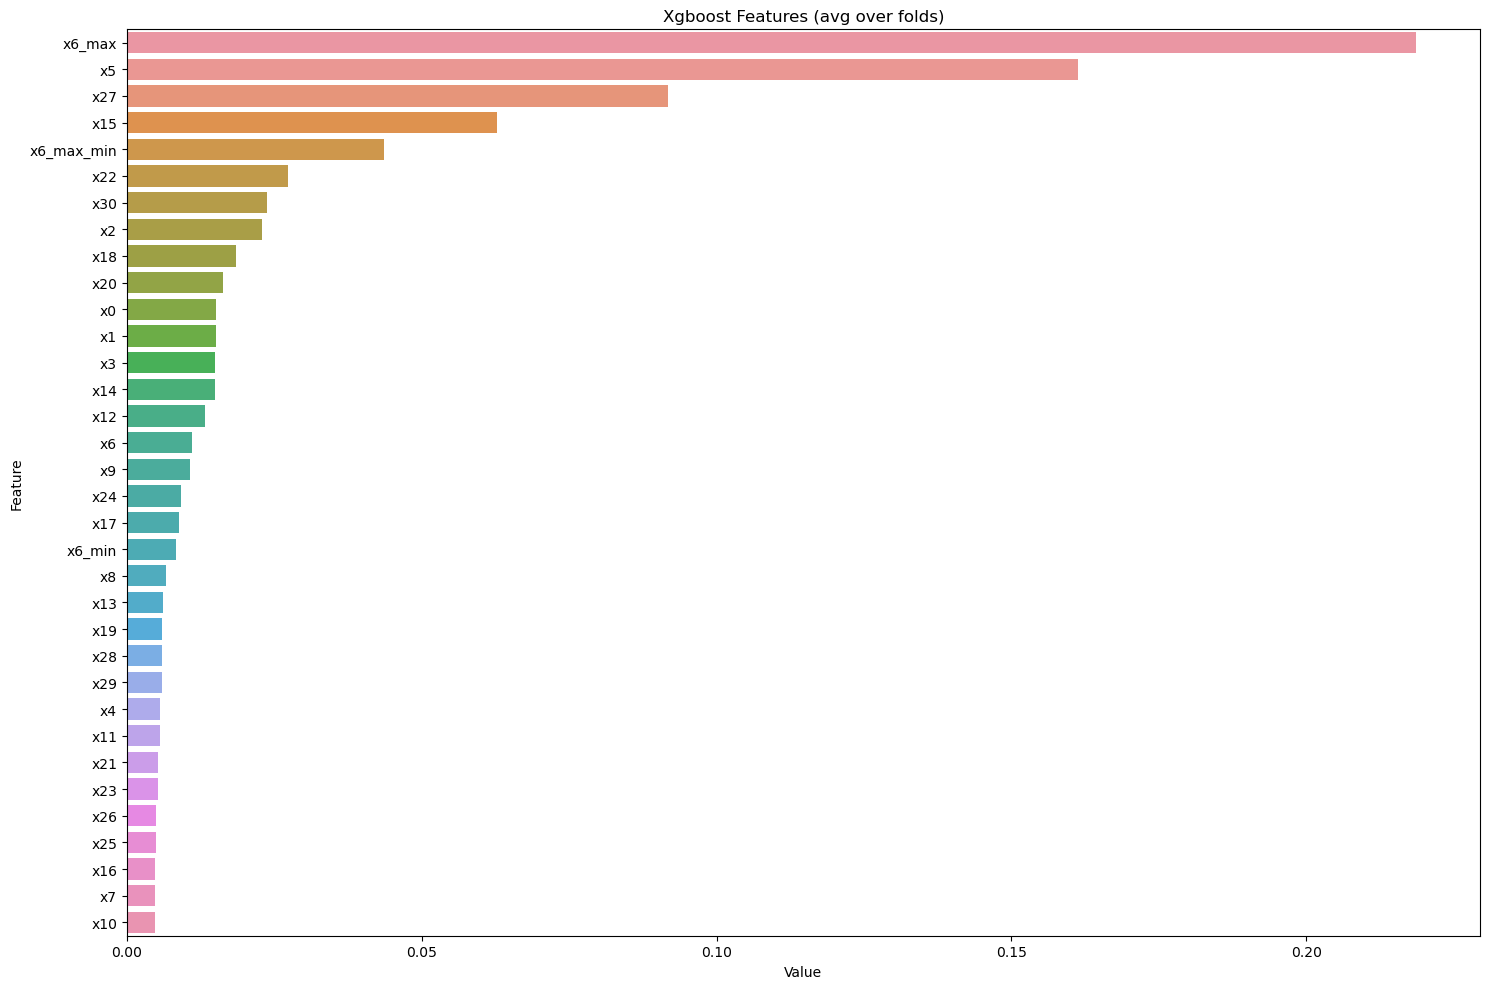

In [59]:

x_train2, x_test2, y_train2, y_test2 = train_test_split(df_train_x13_x3.drop(["x2"],axis =1) , train_data.y ,test_size=0.2,
                                                    random_state=2022,shuffle = True) 

import xgboost

xgb_model1 =xgboost.XGBClassifier(objective='multi:softmax', learning_rate=0.05,
                                  max_depth=7, n_estimators=400,eval_metric = "merror",n_jobs =-1,min_child_weight = 1)
xgb_model1.fit(x_train2,y_train2)


print(xgb_model1.score(x_test2,y_test2))

xgb_model2 =xgboost.XGBClassifier(objective='multi:softmax', learning_rate=0.05,
                                  max_depth=7, n_estimators=400,eval_metric = "merror",n_jobs =-1,min_child_weight = 1)
xgb_model2.fit(df_train_x13_x3.drop(["x2"],axis =1), train_data.y)


feature_imp = pd.DataFrame(sorted(zip(xgb_model1.feature_importances_,df_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=(feature_imp.sort_values(by="Value", ascending=False)))
plt.title('Xgboost Features (avg over folds)')
plt.tight_layout()
plt.show()

In [60]:

def eva2(comb,df_train2):#xgboost
        sco = []
        print("combination length : ",len(comb))

        for _ in range(len(comb)):
            ex = pd.DataFrame()
            ex[df_train2.columns] = df_train2[df_train2.columns]
            for i in range(1): 
                ex = ex.drop([df_train2.columns[comb[_][i]]],axis =1 )

            x_train0, x_test0, y_train0, y_test0 = train_test_split(ex,train_data.y ,
                                                                    test_size=0.2,random_state= 2022,shuffle = True) 

            xgb_model0 =xgboost.XGBClassifier(objective='multi:softmax', learning_rate=0.05,
                                  max_depth=7, n_estimators=400,eval_metric = "merror",n_jobs =-1)
            xgb_model0.fit(x_train0,y_train0)
            sco.append(xgb_model0.score(x_test0,y_test0))
            if (_ % 10) == 0:   
                print(_)
            print("drop ",df_train2.columns[comb[_]]," : " ,xgb_model0.score(x_test0,y_test0))
            
num8 = list(range(0,len(df_train_x13_x3.columns)))
comb8 = list(combinations(num8,1))
eva2(comb8,df_train_x13_x3)

combination length :  37
0
drop  x0  :  0.9167822468793343
drop  x1  :  0.9098474341192788
drop  x2  :  0.9181692094313454
drop  x3  :  0.9070735090152566
drop  x4  :  0.9098474341192788
drop  x5  :  0.912621359223301
drop  x6  :  0.9112343966712899
drop  x7  :  0.9070735090152566
drop  x8  :  0.9098474341192788
drop  x9  :  0.912621359223301
10
drop  x10  :  0.9153952843273232
drop  x11  :  0.912621359223301
drop  x12  :  0.9112343966712899
drop  x13  :  0.9098474341192788
drop  x14  :  0.9112343966712899
drop  x15  :  0.912621359223301
drop  x16  :  0.9140083217753121
drop  x17  :  0.9140083217753121
drop  x18  :  0.9140083217753121
drop  x19  :  0.9112343966712899
20
drop  x20  :  0.9167822468793343
drop  x21  :  0.9084604715672677
drop  x22  :  0.9140083217753121
drop  x23  :  0.9070735090152566
drop  x24  :  0.9112343966712899
drop  x25  :  0.9098474341192788
drop  x26  :  0.9070735090152566
drop  x27  :  0.9140083217753121
drop  x28  :  0.9140083217753121
drop  x29  :  0.90707350

# 앙상블

In [61]:
def score(y,y_):
    cnt = 0
    y = pd.DataFrame(y).reset_index(drop= True)
   
    for _ in range(len(y)):
        if(y_[_] == int(y.iloc[_])):
            cnt = cnt + 1
    print(cnt / len(y)*100)
score(y_test,np.trunc(prd/5))

90.29126213592234


In [62]:
#ad = np.ceil(((xgb_model.predict(train_data.drop(["label","y"],axis = 1)) + lgbm_model2.predict(df_train.drop(["label","y"],axis = 1))))/2)
ad =np.ceil(((lgbm_model3.predict(x_test3) +lgbm_model8.predict(x_test8)+lgbm_model6.predict(x_test6))/3))
#ad = np.trunc(((lgbm_model6.predict(x_test6)+xgb_model1.predict(x_test2)+lgbm_model3.predict(x_test3))/3))
#ad = lgbm_model2.predict(x_test1)
#ad = pd.DataFrame(ad,columns = ["label"])
#ad=lgbm_model6.predict(x_test6)
ad1 =np.ceil(((lgbm_model3.predict(x_test3) +lgbm_model8.predict(x_test8))/2))
ad1

array([2., 0., 2., 0., 0., 5., 2., 5., 1., 0., 1., 3., 0., 2., 2., 0., 4.,
       5., 0., 5., 3., 0., 5., 2., 4., 4., 5., 1., 3., 2., 5., 4., 0., 5.,
       1., 1., 5., 1., 5., 4., 5., 2., 3., 0., 4., 0., 4., 5., 2., 5., 2.,
       1., 4., 0., 5., 5., 3., 0., 5., 5., 0., 0., 0., 0., 2., 0., 1., 5.,
       4., 4., 5., 0., 2., 2., 2., 3., 0., 2., 3., 0., 0., 5., 0., 0., 2.,
       5., 2., 2., 0., 5., 5., 2., 4., 2., 5., 2., 4., 0., 0., 5., 0., 0.,
       0., 5., 4., 0., 2., 2., 4., 0., 5., 4., 2., 5., 0., 0., 5., 2., 4.,
       5., 1., 4., 5., 5., 0., 3., 2., 0., 0., 1., 2., 0., 1., 2., 1., 5.,
       4., 5., 2., 2., 1., 0., 1., 0., 5., 5., 5., 4., 2., 3., 0., 5., 0.,
       5., 5., 2., 2., 4., 0., 1., 1., 0., 4., 1., 4., 2., 3., 0., 0., 0.,
       2., 0., 2., 2., 2., 4., 4., 0., 2., 0., 2., 3., 2., 0., 5., 2., 2.,
       3., 5., 2., 0., 2., 4., 5., 4., 4., 2., 2., 5., 4., 5., 5., 0., 2.,
       2., 4., 2., 3., 4., 1., 1., 0., 5., 5., 4., 1., 4., 3., 5., 0., 4.,
       5., 5., 5., 0., 0.

In [63]:
score(y_test,ad1)

92.09431345353676


# 제출

In [66]:
answer = pd.DataFrame(lgbm_model2.predict(df_test),columns = ["ans"])
answer2 = pd.DataFrame(lgbm_model1.predict(test_data),columns = ["ans"])
answer3 = pd.DataFrame(lgbm_model3.predict(df_test_x13.drop(["x15"],axis =1 )),columns = ["ans"])
answer4 = pd.DataFrame(lgbm_model4.predict(df_test_x28.drop(["x0"],axis =1 )),columns = ["ans"])
#answer5 = pd.DataFrame(lgbm_model5.predict(df_test_x6.drop(["x15"],axis =1 )),columns = ["ans"])
answer6 = pd.DataFrame(lgbm_model6.predict(df_test_x13_x3.drop(["x0"],axis =1 )),columns = ["ans"])
answer7 = pd.DataFrame(xgb_model1.predict(df_test_x13_x3.drop(["x2"],axis =1 )),columns = ["ans"])
answer8 = pd.DataFrame(xgb_model2.predict(df_test_x13_x3.drop(["x2"],axis =1 )),columns = ["ans"])
answer9 = pd.DataFrame(lgbm_model9.predict(df_test_x13_x3.drop(["x0"],axis =1 )),columns = ["ans"])
answer10 = pd.DataFrame(lgbm_model8.predict(df_test3.drop(["x9", "col4_max_min"],axis =1 )),columns = ["ans"])
answer11 = pd.DataFrame((np.ceil((answer3+answer6+answer10)/3)),columns = ["ans"])

print(lgbm_model3.score(x_test3,y_test3))
print(lgbm_model6.score(x_test6,y_test6))
print(lgbm_model8.score(x_test8,y_test8))

def change_label(answer):
    for _ in range(len(answer)):
        if(answer.ans[_] == 0):
            answer["ans"][_] = "A"
        elif(answer.ans[_] == 1):
            answer["ans"][_] = "B"
        elif(answer.ans[_] == 2):
            answer["ans"][_] = "C"
        elif(answer.ans[_] == 3):
            answer["ans"][_] = "D"
        elif(answer.ans[_] == 4):
            answer["ans"][_] = "E"
        elif(answer.ans[_] == 5):
            answer["ans"][_] = "F"
change_label(answer)
change_label(answer2)
change_label(answer3)
change_label(answer4)
#change_label(answer5)
change_label(answer6)
change_label(answer7)
change_label(answer8)
change_label(answer9)
change_label(answer10)
change_label(answer11)

0.9292649098474342
0.9320388349514563
0.9334257975034674


In [68]:
value_count = pd.DataFrame(columns=["lgbm_model1","lgbm_model2","lgbm_model3","lgbm_model4"])
value_count["lgbm_model1"] = answer2["ans"].value_counts()
value_count["lgbm_model2"] = answer["ans"].value_counts()
value_count["lgbm_model3"] = answer3["ans"].value_counts()
value_count["lgbm_model4"] = answer4["ans"].value_counts()
#value_count["lgbm_model5"] = answer5["ans"].value_counts()
value_count["lgbm_model6"] = answer6["ans"].value_counts()
value_count["xgb_model1"] = answer7["ans"].value_counts()
value_count["xgb_model2"] = answer8["ans"].value_counts()
value_count["lgbm_model9"] = answer9["ans"].value_counts()
value_count["lgbm_model8"] = answer10["ans"].value_counts()
value_count["essemble"] = answer11["ans"].value_counts()
value_count

,lgbm_model1,lgbm_model2,lgbm_model3,lgbm_model4,lgbm_model6,xgb_model1,xgb_model2,lgbm_model9,lgbm_model8,essemble
A,363,363,366,364,364,365,366,365,367,359
C,358,366,363,363,359,359,365,361,364,356
F,356,352,346,353,352,343,356,350,360,356
B,165,167,168,166,168,169,168,168,168,172
E,164,163,170,161,164,167,166,166,166,179
D,138,133,131,137,137,141,123,134,119,122


In [69]:
# 제출
answer6.to_csv('./32182779_위정명.csv',index=False)